### Import libraries

In [1]:
from matplotlib import pyplot as plt

import numpy as np

from time import time

import seaborn as sns

from iminuit import Minuit

from functools import partial
from numba import njit

from joblib import Parallel, delayed

from scipy.stats import gaussian_kde
from scipy.stats import binned_statistic_2d

from pathlib import Path
import os, sys

SRC_DIR = str(Path('.').resolve().parents[1])
if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

import utils

### First Chi2 estimation for window

In [2]:
chi2_grid = utils.GridConfig(N=5, is_highres=False)

min_Om_desy3, max_Om_desy3 = np.min(utils.Om_data_arico), np.max(utils.Om_data_arico)
min_sigma8_desy3, max_sigma8_desy3 = np.min(utils.sigma8_data_arico), np.max(utils.sigma8_data_arico)

X, Y = np.meshgrid(chi2_grid.omega_m_vals, chi2_grid.sigma_8_vals)
positions = np.vstack([X.ravel(), Y.ravel()])

values = np.vstack([utils.Om_data_arico, utils.sigma8_data_arico])
kde = gaussian_kde(values)
density = kde(positions).reshape(X.shape)

P = density / np.max(density)
with np.errstate(divide='ignore'):
    delta_chi2_grid_desy3 = -2 * np.log(P)
    delta_chi2_grid_desy3[np.isinf(delta_chi2_grid_desy3)] = np.nanmax(delta_chi2_grid_desy3) + 1

@njit
def find_index(x, x_array, delta_x):
    """Find corresponding index for x in an x_array array.

    Args:
        x (float): the x value we have
            Must be between x_array[0] and x_array[-1]
        x_array (numpy array): the array with all values of x
            Must be linspace and sorted
        delta_x (float): the precision of the linspace array

    Returns:
        int: the corresponding index
    """
    return int((x - x_array[0]) / delta_x + 0.5)

@njit
def chi2_rsd_bao_sn1a_wl(omega_m_array, delta_omega_m, sigma_8_array, delta_sigma_8, z_data_rsd, z_data_panth, z_data_bao, fs8_data, fs8_err_plus, fs8_err_minus, dmrd_data, dmrd_err, n_panth, is_calibrator_panth, m_b_corr_panth, ceph_dist_panth, inv_cov_panth, c, chi2_desy3_grid, omega_m, sigma_8, gamma, rd, H0, M):
    i_omega = find_index(omega_m, omega_m_array, delta_omega_m)
    i_sigma = find_index(sigma_8, sigma_8_array, delta_sigma_8)
    
    chi2_rsd = utils.chi2_functions.chi2_rsd(z_data_rsd, fs8_data, fs8_err_plus, fs8_err_minus, omega_m, sigma_8, gamma)
    chi2_bao = utils.chi2_functions.chi2_bao_dmrd(z_data_bao, dmrd_data, dmrd_err, c, omega_m, rd, H0)
    chi2_panth = utils.chi2_functions.chi2_panth(n_panth, z_data_panth, is_calibrator_panth, m_b_corr_panth, ceph_dist_panth, inv_cov_panth, omega_m, H0, M, c)
    chi2_desy3 = chi2_desy3_grid[i_omega, i_sigma]
    return chi2_rsd + chi2_bao + chi2_panth + chi2_desy3

### Defining parameters
delta_omega_m = chi2_grid.omega_m_vals[1] - chi2_grid.omega_m_vals[0]
delta_sigma_8 = chi2_grid.sigma_8_vals[1] - chi2_grid.sigma_8_vals[0]

delta_chi2_grid_desy3 = np.asarray(delta_chi2_grid_desy3)

chi2_func = partial(
    chi2_rsd_bao_sn1a_wl,
    chi2_grid.omega_m_vals,
    delta_omega_m,
    chi2_grid.sigma_8_vals,
    delta_sigma_8,
    utils.z_data_rsd,
    utils.z_data_panth,
    utils.z_data_bao,
    utils.fs8_data,
    utils.fs8_err_plus,
    utils.fs8_err_minus,
    utils.Dmrd_data,
    utils.Dmrd_err,
    utils.n_panth,
    utils.is_calibrator_panth,
    utils.m_b_corr_panth,
    utils.ceph_dist_panth,
    utils.inv_cov_panth,
    utils.C,
    delta_chi2_grid_desy3
)

In [3]:
params_used = chi2_grid.get_params_used([False, False, False, True, False, True])
initial_params = {"omega_m":utils.OMEGAM_0, "sigma_8":utils.SIGMA_8_0, "gamma":utils.GAMMA, "rd":utils.RD, "H0":utils.H0, "M":utils.M}

minimizer = utils.chi2_functions.get_minimizer(chi2_func, params_used, initial_params)
result = minimizer.migrad()

utils.chi2_functions.display_minimizer(minimizer)
print(result)

Fit results (Chi2 = 1739.451):
omega_m = 0.213 ± 0.007
sigma_8 = 0.703 ± 0.050
gamma = 0.310 ± 0.084
rd = 147.400 ± 1.474
H0 = 74.132 ± 0.169
M = -19.250 ± 0.193
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1739                       │              Nfcn = 123              │
│ EDM = 7.7e-07 (Goal: 0.0002)     │            time = 2.8 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└─

### Calculations

In [4]:
t = time()
chi2_grid.compute(chi2_func, id_grid=1)
t = time() - t
print("chi2_grid 1 calculated in", int(t//60), "min", round(t%60,1), "s.")

# t = time()
# chi2_grid.compute(chi2_func, id_grid=2)
# t = time() - t
# print("chi2_grid 2 calculated in", int(t//60), "min", round(t%60,1), "s.")

# t = time()
# chi2_grid.compute(chi2_func, id_grid=3)
# t = time() - t
# print("chi2_grid 3 calculated in", int(t//60), "min", round(t%60,1), "s.")

chi2_grid 1 calculated in 0 min 26.6 s.


In [29]:
project_root = Path(__file__).parents[2] if "__file__" in globals() else Path().resolve().parents[2]
output_root = project_root / "output"

chi2_grid.save(1, output_root / "4-chi2_RSD_PANTH_DESIDR2_DESY3")

PosixPath('/home/vicpabo/Documents/Projects/Stage-irap/programs/output')

### Plot

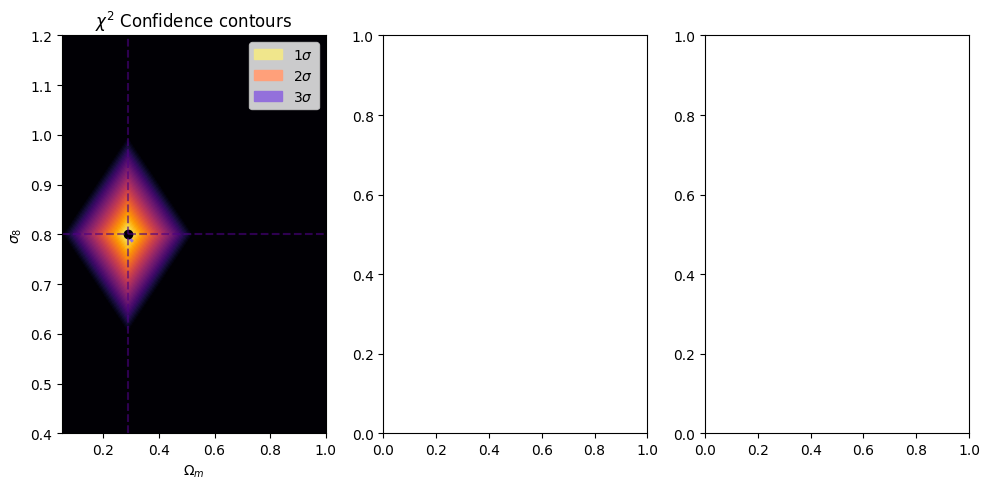

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))

chi2_grid.plot_contours(1, ax=ax[0])